In [98]:
import librosa
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch
from torchvision.transforms import Compose
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import utils
import cv2
from tqdm import tqdm

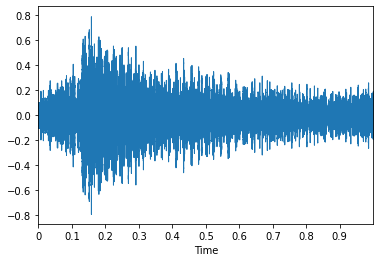

In [2]:
chord = 'F'
no = '4'
file = 'Dataset 01/{}/{}.wav'.format(chord, no)
sig, sr = librosa.load(file, sr = 41000)
librosa.display.waveplot(sig, sr = sr)

In [3]:
n_fft = 1024 # i.e. the window width
hop_length = 64 # Howmuch the wondow will slide. if n_fft > hop_length, then some parts will repeat

## Calculating spectograph acc. to Nvidia
https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/audio/spectrogram.html

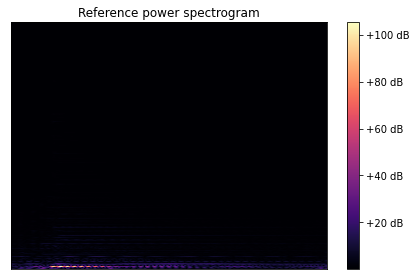

In [4]:
# Without converting amplitude to dB
spectrogram_librosa = np.abs(librosa.stft(sig, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann'))
librosa.display.specshow(spectrogram_librosa, sr=sr)#, y_axis='log', x_axis='time', hop_length=hop_length)
plt.title('Reference power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

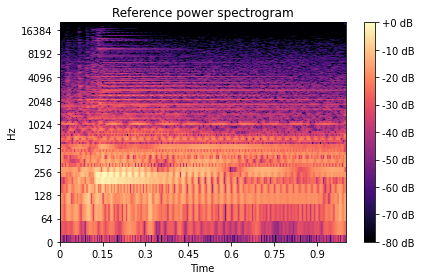

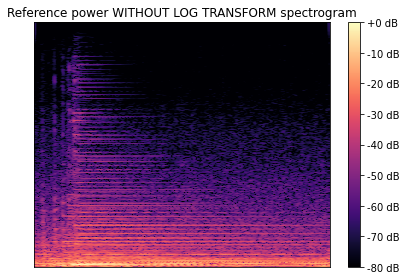

In [11]:
# After converting amplitude to dB
spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa ** 2, ref=np.max)
librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length)
plt.title('Reference power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


# After converting amplitude to dB and plotting WITHOUT LOG TRANSFORM
spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa ** 2, ref=np.max)
# spectrogram_librosa_log = np.log(spectrogram_librosa_db)
librosa.display.specshow(spectrogram_librosa_db, sr=sr, hop_length=hop_length)
plt.title('Reference power WITHOUT LOG TRANSFORM spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [14]:
## Plotting after manual log transforming the frequency:

spectrogram_librosa_log = np.log(spectrogram_librosa_db)
print(spectrogram_librosa_log.shape, spectrogram_librosa_db.shape)
# librosa.display.specshow(spectrogram_librosa_log, sr=sr, hop_length=hop_length)
# plt.title('Reference power WITHOUT LOG TRANSFORM spectrogram')
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()
# plt.show()

(513, 641) (513, 641)


/home/pyf/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pyf/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


**NOTE:** `librosa.core.amplitude_to_db(S)` is same as `librosa.power_to_db(S **2 )`

### Making spectograph acc to https://www.youtube.com/watch?v=Oa_d-zaUti8&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=11


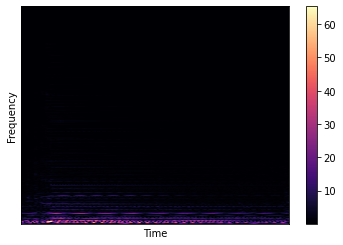

In [25]:
stft = librosa.core.stft(sig, n_fft = n_fft, hop_length = hop_length)
stft.shape
spectogram = np.abs(stft)
#Plotting without log
librosa.display.specshow(spectogram, sr = sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

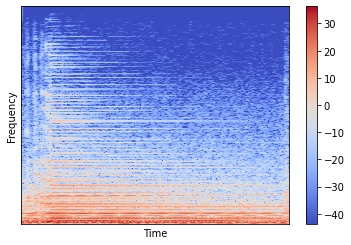

In [26]:
log_spectogram = librosa.core.amplitude_to_db(spectogram)
librosa.display.specshow(log_spectogram, sr = sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [27]:
log_spectogram.shape

(513, 641)

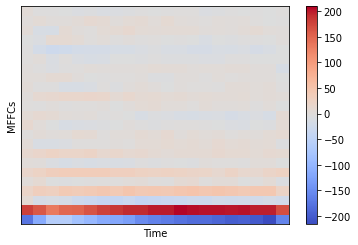

In [8]:
MFFCs = librosa.feature.mfcc(sig, n_fft = n_fft, hop_length = hop_length, n_mfcc = 23)
librosa.display.specshow(MFFCs, sr = sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("MFFCs")
plt.colorbar()
plt.show()

## Cool, so I'll be using the NVIDIA's method to make spectograms

## Plotting different chord's spectograms to see how it looks:

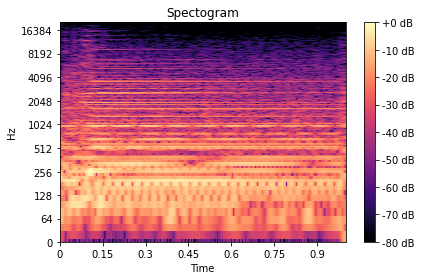

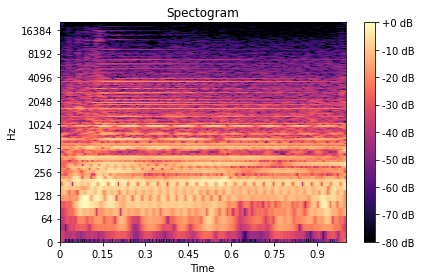

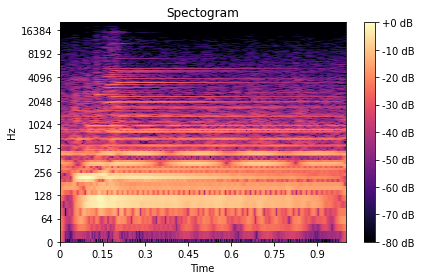

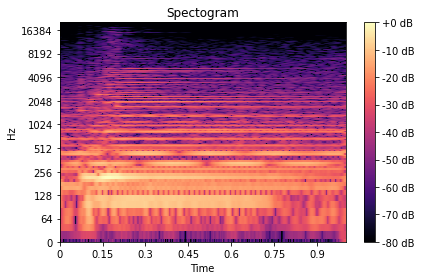

(1025, 641)

In [26]:
y_axis = 'cqt_note'
chord = 'C'
no = '4'
file = 'Dataset 01/{}/{}.wav'.format(chord, no)
obj = utils.AudioUtils(n_fft = 2048, hop_length = 8)
c4 = obj.fileToSpecto(file)
obj.showSpecto(c4, y_axis = y_axis)
c4.shape

chord = 'C'
no = '3'
file = 'Dataset 01/{}/{}.wav'.format(chord, no)
obj = utils.AudioUtils(n_fft = 2048, hop_length = 64)
c4 = obj.fileToSpecto(file)
obj.showSpecto(c4, y_axis = y_axis)
c4.shape

chord = 'A_barre'
no = '1'
file = 'Dataset 01/{}/{}.wav'.format(chord, no)
c4 = obj.fileToSpecto(file)
obj.showSpecto(c4, y_axis = y_axis)
c4.shape

chord = 'A_barre'
no = '8'
file = 'Dataset 01/{}/{}.wav'.format(chord, no)
c4 = obj.fileToSpecto(file)
obj.showSpecto(c4, y_axis = y_axis)
c4.shape


In [6]:
X, y = np.zeros((1, 1025, 641)), []
obj = utils.AudioUtils(n_fft = 2048, hop_length = 64)
chords = ['C', 'A_barre', 'F', 'G_open']
file = file = 'Dataset 01/{}/{}.wav'#.format(chord, no)
one_hot_vector = {chord: i for i, chord in enumerate(chords)}
for chord in chords:
    for i in range(1,11):
        spectro = obj.fileToSpecto(file.format(chord, str(i)))
        y_vec = [0 for _ in range(len(chords))]
        y_vec[one_hot_vector[chord]] = 1
        
        # Padding by adding 0's.
        if spectro.shape[1]!=641:
            temp = np.zeros((1025, 641))
            temp[:spectro.shape[0], :spectro.shape[1]] = spectro
            spectro = temp
            
        X = np.concatenate((X, spectro.reshape(1, 1025, 641)), axis = 0)
        y.append(y_vec)
        
    
X = X[1:]
X.shape, len(y)

X_rescale = []
l = 1024
for x in X:
    re = cv2.resize(x, (l, l))
    X_rescale.append(re)
    
len(X_rescale), X_rescale[0].shape

(40, (1024, 1024))

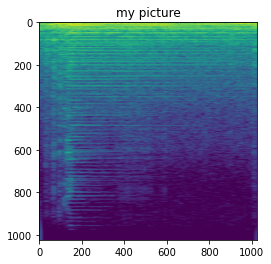

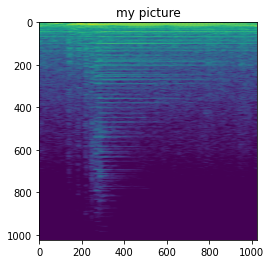

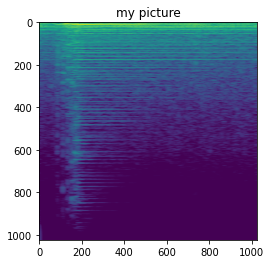

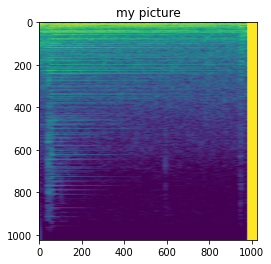

In [15]:
plt.imshow(X_rescale[2])
plt.title('my picture')
plt.show()

plt.imshow(X_rescale[12])
plt.title('my picture')
plt.show()

plt.imshow(X_rescale[24])
plt.title('my picture')
plt.show()

plt.imshow(X_rescale[34])
plt.title('my picture')
plt.show()

# Building torch NN

## Using torch's Dataset class for making custom dataset class
Based on this: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [85]:
class Resize():
    def __init__(self, resize_dim = 1024):
        self.resize_dim = 1024
        
    def __call__(self, spectro):
        return cv2.resize(spectro, (self.resize_dim, self.resize_dim))
    
class MinMaxNorm():
    def __call__(self, spectro):
        return (spectro-spectro.min())/(spectro.max()-spectro.min())
    

# torchvision.transforms.Compose takes input a list of classes that are the transformations on your 
# sample. The way you're supposed to write these transformation classes is that you've to write the transformation 
# logic in the '__call__' of each class. torchvision.transforms.Compose will sequentially pass your sample (i.e. when it is called 
# inside the __getitem__) through all the transformation classes (by calling these classes's __call__ method.). 
trans = Compose([Resize(1024), MinMaxNorm()])

class ChordDataset(Dataset):
    def __init__(self, parent_loc = 'Dataset 01', chords = ['C', 'F', 'A_barre', 'G_open'], transform = None):
        self.obj = utils.AudioUtils(n_fft = 2048, hop_length = 64)
        self.file_locs = []
        self.chords = {chord:i for i, chord in enumerate(chords)}
        self.transform = transform
#         self.dirs = []
        for chord in self.chords.keys():
            chord_dir = os.path.join(parent_loc, chord, '')
            files = glob.glob(chord_dir+'*.wav')
            for file in files:
                self.file_locs.append([file, chord])
        
    def __len__(self):
        return len(self.file_locs)
    
    def __getitem__(self, idx):
        x_loc, y = self.file_locs[idx]
        y_vec = [0 for _ in range(len(self.chords))]
        y_vec[self.chords[y]] = 1
#         print(y_vec)
        spectro = self.obj.fileToSpecto(x_loc)
        
        # Padding 0's. If you're changing the n_fft or hop_length, the dims of  
        # each spectrogram (i.e.1025, 641 in this case) will change corrospondingly.  
        if spectro.shape[1]!=641:
            temp = np.zeros((1025, 641))
            temp[:spectro.shape[0], :spectro.shape[1]] = spectro
            spectro = temp
        
        if self.transform:
            spectro = self.transform(spectro)
        
        spectro = torch.tensor(spectro).reshape(1, spectro.shape[0], spectro.shape[1])
        y_vec = torch.tensor(y_vec) # If you do not convert this into torch.tensor, it gives some weired results when used with dataloader. Try commenting this line and then running the dataloader vala cell. 
        sample = {'x': spectro.type(torch.FloatTensor), 'y':y_vec} # The dataloader was throwing some error without .type(torch.FloatTensor)
        return sample
    
ds = ChordDataset(transform = trans)
ds[1]['y']#.shape

tensor([1, 0, 0, 0])

In [86]:
# Checking how the dataset is working:
for i in range(len(ds)):
    print(i, ds[i]['x'].shape, ds[i]['y'])
    
print(":') works so beautifully !!")


0 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
1 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
2 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
3 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
4 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
5 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
6 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
7 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
8 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
9 torch.Size([1, 1024, 1024]) tensor([1, 0, 0, 0])
10 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
11 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
12 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
13 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
14 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
15 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
16 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
17 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
18 torch.Size([1, 1024, 1024]) tensor([0, 1, 0, 0])
19 torch.Size([1, 1024

#### Making dataloader for our previously made dataset:
this is because dataloader will give is batch functionality B|

In [87]:
loader = DataLoader(ds, batch_size = 5, shuffle = True)

for i, batch in enumerate(loader):
    print(i, batch['x'].shape, batch['y'].shape)

0 torch.Size([5, 1, 1024, 1024]) torch.Size([5, 4])
1 torch.Size([5, 1, 1024, 1024]) torch.Size([5, 4])
2 torch.Size([5, 1, 1024, 1024]) torch.Size([5, 4])
3 torch.Size([5, 1, 1024, 1024]) torch.Size([5, 4])
4 torch.Size([5, 1, 1024, 1024]) torch.Size([5, 4])
5 torch.Size([5, 1, 1024, 1024]) torch.Size([5, 4])
6 torch.Size([5, 1, 1024, 1024]) torch.Size([5, 4])
7 torch.Size([5, 1, 1024, 1024]) torch.Size([5, 4])


In [143]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5) # (Input no. of filter, output no. of filter, kernel size)
        self.conv1_bn = nn.BatchNorm2d(3)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(3, 6, 5)
        self.conv2_bn = nn.BatchNorm2d(6)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(6, 12, 3)
        self.conv3_bn = nn.BatchNorm2d(12)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        
        
        self.fc1 = nn.Linear(12 * 125 * 125, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc2_bn = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
#         print(x.shape)
        x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
#         print(x.shape)
        x = self.pool3(F.relu(self.conv3_bn(self.conv3(x))))
#         print(x.shape)
        x = self.dropout1(x)
#         print(x.shape)
        x = x.view(-1, 12*125*125)
#         print(x.shape)
        x = F.relu(self.fc1(x))
#         print(x.shape)
        x = F.relu(self.fc2_bn(self.fc2(x)))
#         print(x.shape)
        x = F.relu(self.fc3(x))
#         print(x.shape)
        x = F.sigmoid(self.output(x))
        return x
    
    
mdl = Net()
mdl = mdl.float() # Doing this step, because without this, it throws some error :/
loader = DataLoader(ds, batch_size = 5, shuffle = True)

# Making a forward pass to see if everything is working well -- ?
for i, batch in enumerate(loader):
    v = mdl(batch['x'])

v
# OMG !!! IT'S WORKING GREAT :"DDDDDDDDDD

tensor([[0.4725, 0.5445, 0.4587, 0.4552],
        [0.5105, 0.5377, 0.4025, 0.4075],
        [0.5180, 0.5323, 0.4249, 0.4138],
        [0.5301, 0.5091, 0.4430, 0.4448],
        [0.4949, 0.5471, 0.4168, 0.4171]], grad_fn=<SigmoidBackward>)

### Now making a training loop:

**First training on a single batch**

In [144]:
batch = next(iter(loader))
X, y = batch['x'], batch['y']
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mdl.parameters(), lr=0.01, momentum=0.5)

pred = mdl(X)
loss = criterion(pred, y.argmax(axis = 1)) # This criterion function takes input of (batch_size, num_of_classes) (i.e. (5,4) in our case) as predicted value and (batch_size, class_index) 
# (i.e. (5, 1) shape in our case) as the labels. So you do not need to pass one_hot_encoded vector as your labels. Just the class index works. 
print(loss.item())

loss.backward()

optimizer.step()

pred = mdl(X)
loss = criterion(pred, y.argmax(axis = 1))
print(loss.item())

1.4004089832305908
1.369592308998108


**Second, training on entire batches for a single epoch**

In [147]:
def accuracy(y_pred, y_lbl):
    correct = pred.argmax(axis = 1).eq(y.argmax(axis = 1)).sum().item()
    return correct/len(y_pred)


mdl = Net()
mdl = mdl.float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mdl.parameters(), lr = 0.01, momentum = 0.5)

total_loss = 0
tot_avg_acc = 0

for i, batch in enumerate(loader):
    X, y = batch['x'], batch['y']
    pred = mdl(X)
    loss = criterion(pred, y.argmax(axis = 1))
    print('Loss:',loss.item(), '| Accuracy:', accuracy(pred, y))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_loss+=loss.item()
    tot_avg_acc+= accuracy(pred, y)
    
avg_epoch_acc = tot_avg_acc / len(loader)
print('Total loss of 1 epoch', total_loss, '| Avg acc of 1 epoch:', avg_epoch_acc)

Loss: 1.3609178066253662 | Accuracy: 0.8
Loss: 1.3574508428573608 | Accuracy: 0.6
Loss: 1.4003784656524658 | Accuracy: 0.0
Loss: 1.3846909999847412 | Accuracy: 0.4
Loss: 1.3940657377243042 | Accuracy: 0.2
Loss: 1.3694496154785156 | Accuracy: 0.2
Loss: 1.3831253051757812 | Accuracy: 0.2
Loss: 1.3448294401168823 | Accuracy: 0.6
Total loss of 1 epoch 10.994908213615417 | Avg acc of 1 epoch: 0.375


**FINALLY NOW TRAINING ON MULTIPLE EPOCHS**

In [152]:
epochs = 5
mdl = Net()
mdl = mdl.float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mdl.parameters(), lr = 0.01, momentum = 0.5)
                                                                                                                                                                                                                
for epoch in range(epochs):
    total_loss = 0
    tot_avg_acc = 0

                                                                                                                                                                                                                                                                                                                                                                                                                                                            for i, batch in tqdm(enumerate(loader)):
        X, y = batch['x'], batch['y']
        pred = mdl(X)
        loss = criterion(pred, y.argmax(axis = 1))
        # print('Loss:',loss.item(), '| Accuracy:', accuracy(pred, y))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        tot_avg_acc+= accuracy(pred, y)

    avg_epoch_acc = tot_avg_acc / len(loader)
    print(f'{epoch}. Loss: {total_loss} | Avg epoch accuracy: {avg_epoch_acc}')

8it [00:18,  2.34s/it]
0it [00:00, ?it/s]

0. Loss: 10.989680171012878 | Avg epoch accuracy: 0.45


8it [00:24,  3.02s/it]
0it [00:00, ?it/s]

1. Loss: 10.807541370391846 | Avg epoch accuracy: 0.5


8it [00:24,  3.02s/it]
0it [00:00, ?it/s]

2. Loss: 10.746660947799683 | Avg epoch accuracy: 0.5499999999999999


8it [00:26,  3.35s/it]
0it [00:00, ?it/s]

3. Loss: 10.598222374916077 | Avg epoch accuracy: 0.55


8it [00:25,  3.18s/it]

4. Loss: 10.5912504196167 | Avg epoch accuracy: 0.525


 12%|█▎        | 1/8 [00:01<00:10,  1.53s/it]

{'x': tensor([[[[0.5265, 0.5269, 0.5270,  ..., 0.5887, 0.5873, 0.5863],
          [0.5482, 0.5471, 0.5453,  ..., 0.5945, 0.5990, 0.6020],
          [0.5626, 0.5642, 0.5671,  ..., 0.6686, 0.6686, 0.6686],
          ...,
          [0.0272, 0.0268, 0.0260,  ..., 0.0000, 0.0000, 0.0000],
          [0.0270, 0.0266, 0.0258,  ..., 0.0000, 0.0000, 0.0000],
          [0.0268, 0.0263, 0.0255,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.7138, 0.7133, 0.7126,  ..., 1.0000, 1.0000, 1.0000],
          [0.7167, 0.7162, 0.7153,  ..., 1.0000, 1.0000, 1.0000],
          [0.6871, 0.6870, 0.6868,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0410, 0.0405, 0.0397,  ..., 1.0000, 1.0000, 1.0000],
          [0.0411, 0.0407, 0.0399,  ..., 1.0000, 1.0000, 1.0000],
          [0.0412, 0.0408, 0.0400,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.6684, 0.6679, 0.6672,  ..., 0.8044, 0.8068, 0.8085],
          [0.6581, 0.6577, 0.6569,  ..., 0.8119, 0.8127, 0.8131],
          [0.7664, 0.7660, 0.765

 25%|██▌       | 2/8 [00:02<00:07,  1.23s/it]

{'x': tensor([[[[0.6645, 0.6647, 0.6648,  ..., 0.6662, 0.6680, 0.6692],
          [0.6646, 0.6634, 0.6617,  ..., 0.6661, 0.6674, 0.6683],
          [0.6172, 0.6184, 0.6198,  ..., 0.6323, 0.6333, 0.6339],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.5535, 0.5533, 0.5523,  ..., 0.5568, 0.5589, 0.5603],
          [0.5516, 0.5510, 0.5504,  ..., 0.5788, 0.5802, 0.5810],
          [0.6874, 0.6873, 0.6869,  ..., 0.5952, 0.5966, 0.5977],
          ...,
          [0.1902, 0.1898, 0.1890,  ..., 0.0000, 0.0000, 0.0000],
          [0.1901, 0.1897, 0.1889,  ..., 0.0000, 0.0000, 0.0000],
          [0.1901, 0.1897, 0.1889,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.8401, 0.8395, 0.8385,  ..., 0.7633, 0.7646, 0.7655],
          [0.8569, 0.8565, 0.8558,  ..., 0.7717, 0.7730, 0.7738],
          [0.8518, 0.8515, 0.851

 38%|███▊      | 3/8 [00:02<00:05,  1.00s/it]

{'x': tensor([[[[0.5963, 0.5962, 0.5960,  ..., 0.6132, 0.6129, 0.6125],
          [0.5972, 0.5964, 0.5950,  ..., 0.6187, 0.6222, 0.6246],
          [0.6239, 0.6237, 0.6232,  ..., 0.6692, 0.6696, 0.6698],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0723, 0.0739, 0.0749],
          [0.0000, 0.0000, 0.0000,  ..., 0.0720, 0.0736, 0.0746],
          [0.0000, 0.0000, 0.0000,  ..., 0.0718, 0.0734, 0.0744]]],


        [[[0.6492, 0.6505, 0.6522,  ..., 0.6277, 0.6287, 0.6294],
          [0.6930, 0.6913, 0.6886,  ..., 0.5716, 0.5713, 0.5712],
          [0.7274, 0.7280, 0.7288,  ..., 0.6324, 0.6339, 0.6349],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.6258, 0.6245, 0.6225,  ..., 0.6914, 0.6939, 0.6956],
          [0.5900, 0.5910, 0.5924,  ..., 0.6267, 0.6220, 0.6187],
          [0.4822, 0.4782, 0.472

 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

{'x': tensor([[[[0.6718, 0.6714, 0.6707,  ..., 0.6941, 0.6972, 0.6992],
          [0.6575, 0.6570, 0.6563,  ..., 0.7232, 0.7238, 0.7242],
          [0.6298, 0.6294, 0.6285,  ..., 0.7484, 0.7505, 0.7518],
          ...,
          [0.0808, 0.0803, 0.0795,  ..., 0.1742, 0.1758, 0.1768],
          [0.0808, 0.0803, 0.0796,  ..., 0.1742, 0.1758, 0.1768],
          [0.0808, 0.0804, 0.0796,  ..., 0.1742, 0.1758, 0.1768]]],


        [[[0.6814, 0.6808, 0.6797,  ..., 0.5468, 0.5556, 0.5615],
          [0.6722, 0.6719, 0.6715,  ..., 0.4670, 0.4296, 0.4025],
          [0.6236, 0.6231, 0.6223,  ..., 0.6346, 0.6310, 0.6286],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0616, 0.0632, 0.0642],
          [0.0000, 0.0000, 0.0000,  ..., 0.0616, 0.0632, 0.0642],
          [0.0000, 0.0000, 0.0000,  ..., 0.0614, 0.0630, 0.0641]]],


        [[[0.6103, 0.6103, 0.6101,  ..., 0.6301, 0.6330, 0.6349],
          [0.6154, 0.6145, 0.6131,  ..., 0.6151, 0.6147, 0.6143],
          [0.5245, 0.5273, 0.531

 62%|██████▎   | 5/8 [00:03<00:02,  1.34it/s]

{'x': tensor([[[[0.7375, 0.7369, 0.7358,  ..., 1.0000, 1.0000, 1.0000],
          [0.7590, 0.7586, 0.7579,  ..., 1.0000, 1.0000, 1.0000],
          [0.7624, 0.7620, 0.7615,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.6830, 0.6824, 0.6813,  ..., 1.0000, 1.0000, 1.0000],
          [0.6867, 0.6864, 0.6859,  ..., 1.0000, 1.0000, 1.0000],
          [0.7391, 0.7385, 0.7375,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.2073, 0.2069, 0.2061,  ..., 1.0000, 1.0000, 1.0000],
          [0.2073, 0.2069, 0.2061,  ..., 1.0000, 1.0000, 1.0000],
          [0.2073, 0.2068, 0.2060,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.7297, 0.7290, 0.7276,  ..., 1.0000, 1.0000, 1.0000],
          [0.7329, 0.7327, 0.7324,  ..., 1.0000, 1.0000, 1.0000],
          [0.8106, 0.8100, 0.809

 75%|███████▌  | 6/8 [00:04<00:01,  1.49it/s]

{'x': tensor([[[[0.6065, 0.6050, 0.6028,  ..., 1.0000, 1.0000, 1.0000],
          [0.5973, 0.5980, 0.5988,  ..., 1.0000, 1.0000, 1.0000],
          [0.4462, 0.4490, 0.4545,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.8340, 0.8334, 0.8325,  ..., 0.6515, 0.6558, 0.6589],
          [0.8481, 0.8477, 0.8470,  ..., 0.6285, 0.6255, 0.6231],
          [0.8614, 0.8610, 0.8602,  ..., 0.5742, 0.5837, 0.5902],
          ...,
          [0.0995, 0.0991, 0.0983,  ..., 0.0545, 0.0561, 0.0571],
          [0.0993, 0.0988, 0.0980,  ..., 0.0546, 0.0562, 0.0572],
          [0.0995, 0.0991, 0.0983,  ..., 0.0549, 0.0565, 0.0575]]],


        [[[0.6869, 0.6860, 0.6845,  ..., 0.4989, 0.4890, 0.4821],
          [0.7607, 0.7606, 0.7602,  ..., 0.6546, 0.6579, 0.6601],
          [0.5817, 0.6074, 0.644

 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

{'x': tensor([[[[0.5201, 0.5225, 0.5265,  ..., 0.5951, 0.5961, 0.5967],
          [0.6429, 0.6416, 0.6394,  ..., 0.6313, 0.6340, 0.6357],
          [0.7399, 0.7400, 0.7402,  ..., 0.6672, 0.6678, 0.6682],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1360, 0.1379, 0.1391],
          [0.0000, 0.0000, 0.0000,  ..., 0.1360, 0.1378, 0.1390],
          [0.0000, 0.0000, 0.0000,  ..., 0.1360, 0.1378, 0.1390]]],


        [[[0.6869, 0.6860, 0.6845,  ..., 0.4989, 0.4890, 0.4821],
          [0.7607, 0.7606, 0.7602,  ..., 0.6546, 0.6579, 0.6601],
          [0.5817, 0.6074, 0.6441,  ..., 0.7565, 0.7562, 0.7561],
          ...,
          [0.1686, 0.1681, 0.1673,  ..., 0.3164, 0.3182, 0.3194],
          [0.1686, 0.1681, 0.1673,  ..., 0.3163, 0.3182, 0.3193],
          [0.1686, 0.1682, 0.1674,  ..., 0.3163, 0.3181, 0.3193]]],


        [[[0.4861, 0.4839, 0.4802,  ..., 0.5895, 0.5913, 0.5924],
          [0.5245, 0.5252, 0.5262,  ..., 0.5919, 0.5933, 0.5943],
          [0.5989, 0.5980, 0.596

100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

{'x': tensor([[[[0.6047, 0.6028, 0.5999,  ..., 0.8165, 0.8178, 0.8186],
          [0.6485, 0.6489, 0.6494,  ..., 0.8332, 0.8353, 0.8366],
          [0.7803, 0.7798, 0.7788,  ..., 0.8507, 0.8516, 0.8522],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0632, 0.0648, 0.0658],
          [0.0000, 0.0000, 0.0000,  ..., 0.0635, 0.0651, 0.0661],
          [0.0000, 0.0000, 0.0000,  ..., 0.0638, 0.0654, 0.0664]]],


        [[[0.6617, 0.6611, 0.6601,  ..., 0.5388, 0.5427, 0.5453],
          [0.6740, 0.6737, 0.6730,  ..., 0.5330, 0.5318, 0.5309],
          [0.6825, 0.6821, 0.6813,  ..., 0.6214, 0.6239, 0.6255],
          ...,
          [0.0712, 0.0708, 0.0700,  ..., 0.0631, 0.0647, 0.0658],
          [0.0716, 0.0712, 0.0704,  ..., 0.0633, 0.0649, 0.0659],
          [0.0720, 0.0716, 0.0708,  ..., 0.0634, 0.0650, 0.0660]]],


        [[[0.5229, 0.5234, 0.5242,  ..., 0.4634, 0.4740, 0.4805],
          [0.5008, 0.4993, 0.4967,  ..., 0.4728, 0.4706, 0.4693],
          [0.5114, 0.5119, 0.512